In [8]:
# Verify environment started correctly
%pip list

Package            Version
------------------ --------
appnope            0.1.3
asttokens          2.2.1
backcall           0.2.0
certifi            2023.5.7
charset-normalizer 3.1.0
comm               0.1.3
contourpy          1.1.0
cycler             0.11.0
debugpy            1.6.7
decorator          5.1.1
executing          1.2.0
filelock           3.12.2
fonttools          4.40.0
idna               3.4
ipykernel          6.23.3
ipython            8.14.0
jedi               0.18.2
Jinja2             3.1.2
jupyter_client     8.3.0
jupyter_core       5.3.1
kiwisolver         1.4.4
MarkupSafe         2.1.3
matplotlib         3.7.1
matplotlib-inline  0.1.6
mpmath             1.3.0
nest-asyncio       1.5.6
networkx           3.1
numpy              1.25.0
packaging          23.1
parso              0.8.3
pexpect            4.8.0
pickleshare        0.7.5
Pillow             9.5.0
pip                23.1.2
platformdirs       3.8.0
prompt-toolkit     3.0.38
psutil             5.9.5
ptyprocess   

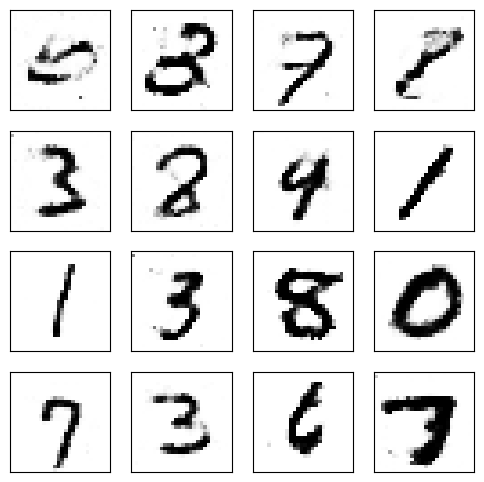

Epoch [200/200], Step[600/600], d_loss: 1.1717, g_loss: 0.8493, D(x): 0.60, D(G(z)): 0.45


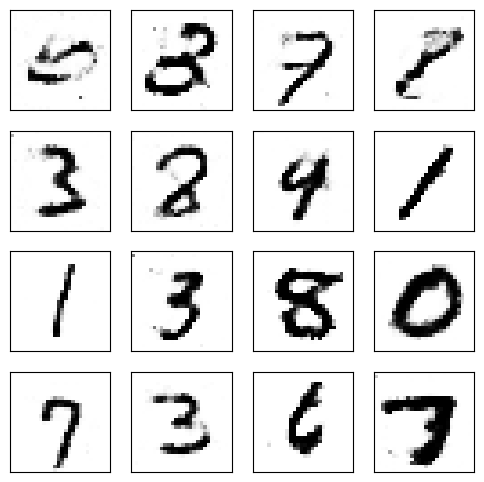

In [9]:
'''
Source: https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb
To setup this up use: https://www.geeksforgeeks.org/using-jupyter-notebook-in-virtual-environment/
Basically we have to set kernel for the jupyter notebook.
'''

# Boilerplate for each experiment file. To allow for module calling and messy relative path issues
import sys
import os
from dotenv import load_dotenv
load_dotenv()
basePath = os.getenv('basePath')
sys.path.insert(1,basePath) # For modules
os.chdir(basePath) # Every relative path now from basePath

import itertools
import math
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
%matplotlib inline

# Load data
mnistPath = "./Dataset/DatasetFiles"
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = dsets.MNIST(mnistPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

# Model defination
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out.squeeze()

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out.squeeze()

discriminator = Discriminator()
generator = Generator()

# Optimization
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# Training
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200 
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = Variable(images)
        real_labels = Variable(torch.ones(images.size(0)))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig('Figure/Experiment/GithubPytorchMnist/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                    real_score.data.mean(), fake_score.data.mean()))


In [10]:
# Save model
saveGeneratorModelPath = "./Model/TrainedModel/GithubPytorchMnistGAN/Generator" + "_dim100" \
    + "_batchSize100" + "_numEpochs" + str(num_epochs) + ".pt"
saveDiscriminatorModelPath = "./Model/TrainedModel/GithubPytorchMnistGAN/Discriminator" + "_dim100" \
    + "_batchSize100" + "_numEpochs" + str(num_epochs) + ".pt"
torch.save(generator.state_dict(), saveGeneratorModelPath)
torch.save(discriminator.state_dict(), saveDiscriminatorModelPath)
